In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import plot_importance

In [2]:
df = pd.read_csv('features_cleaned.csv')

In [3]:
df.shape

(606, 17)

In [4]:
df = df[df.Species.isin(['Clouded leopard','Snow leopard', 'Jaguar','Leopard','Lion'])]

In [5]:
df.shape

(143, 17)

In [6]:
df.columns

Index(['Partials', 'Zero_Crossings', 'Duration', 'Amp_range', 'Avg_amp',
       'Freq_range', 'Pulses_per_Sec', 'MFCC', 'Spectral Rolloff',
       'Melspectrogram', 'Spectral Contrast', 'Chroma_StFt', 'Tonnetz', 'Sex',
       'Age', 'Species', 'Call'],
      dtype='object')

In [7]:
X = df[pd.notnull(df['Call'])].drop(['Call','Sex','Age','Species'], axis=1)
y = df[pd.notnull(df['Call'])][['Call','Species']]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 13)
(43, 13)
(100, 2)
(43, 2)


In [10]:
print('Total Call Values')
print(df['Call'].value_counts())
print('\n')
print('Call values for Training')
print(y_train.Call.value_counts())
print('\n')
print('Call values for Testing')
print(y_test.Call.value_counts())

Total Call Values
roar       65
prusten    44
growl      20
hiss        6
puff        5
mew         3
Name: Call, dtype: int64


Call values for Training
roar       44
prusten    31
growl      15
puff        4
mew         3
hiss        3
Name: Call, dtype: int64


Call values for Testing
roar       21
prusten    13
growl       5
hiss        3
puff        1
Name: Call, dtype: int64


In [11]:
print('Calls trained for but not tested for')
print(set(np.unique(y_train.Call))-set(np.unique(y_test.Call)))
print('Calls test for but not trained for')
print(set(np.unique(y_test.Call))-set(np.unique(y_train.Call)))

Calls trained for but not tested for
{'mew'}
Calls test for but not trained for
set()


In [12]:
print('Total Species values')
print(df['Species'].value_counts())
print('\n')
print('Species values for Training')
print(y_train.Species.value_counts())
print('\n')
print('Species values for Testing')
print(y_test.Species.value_counts())

Total Species values
Leopard            45
Clouded leopard    35
Lion               34
Jaguar             22
Snow leopard        7
Name: Species, dtype: int64


Species values for Training
Leopard            28
Clouded leopard    25
Lion               25
Jaguar             17
Snow leopard        5
Name: Species, dtype: int64


Species values for Testing
Leopard            17
Clouded leopard    10
Lion                9
Jaguar              5
Snow leopard        2
Name: Species, dtype: int64


In [13]:
print('Species trained for but not tested for')
print(set(np.unique(y_train.Species))-set(np.unique(y_test.Species)))
print('Species test for but not trained for')
print(set(np.unique(y_test.Species))-set(np.unique(y_train.Species)))

Species trained for but not tested for
set()
Species test for but not trained for
set()


# Vocalization Classification

## Splitting data

In [14]:
y_train1 = y_train.Call
y_test1 = y_test.Call

## LightGBM

In [15]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier()
lgb.fit(X_train, y_train1)

LGBMClassifier()

In [16]:
lgb.score(X_train, y_train1)

1.0

In [17]:
lgb.score(X_test,y_test1)

0.7906976744186046

## XGBoost

In [18]:
parameters = dict(
    objective='multi:softprob',
    random_state = 30,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.4,
    tree_method='gpu_hist')


clf = XGBClassifier(**parameters, n_estimators=1200)

In [19]:
clf.fit(X_train, y_train1)

C:\Users\exant\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:30:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1200, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=30, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [20]:
clf.score(X_train, y_train1)

1.0

In [21]:
clf.score(X_test,y_test1)

0.7674418604651163

In [22]:
y_pred = clf.predict(X_test)

In [23]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_pred))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_pred)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'prusten' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'puff', 'hiss'}


Accuracy 0.7674418604651163


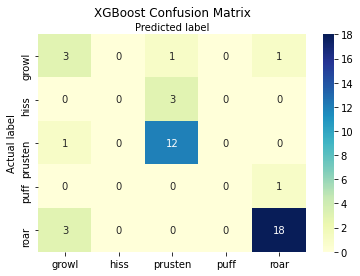

In [24]:
names = sorted(list(set(np.unique(y_test1)).union(set(y_pred))))

print('Accuracy',clf.score(X_test, y_test1))

cnf = confusion_matrix(y_test1, y_pred)
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))
sns.heatmap(cnf, annot = True, xticklabels = names, cmap= "YlGnBu", yticklabels = names)
ax.xaxis.set_label_position('top')
plt.title('XGBoost Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

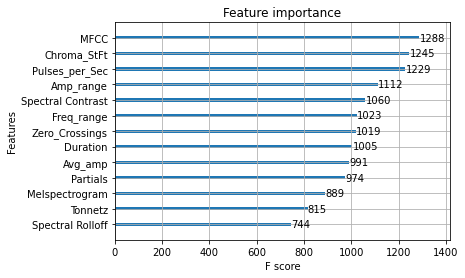

In [25]:
plot_importance(clf)
figsize=(5,10)

## SVM

In [26]:
clf_svc = SVC()

In [27]:
clf_svc.fit(X_train, y_train1)

SVC()

In [28]:
clf_svc.score(X_train, y_train1)

0.83

In [29]:
clf_svc.score(X_test, y_test1)

0.9069767441860465

In [30]:
y_pred_svc=clf_svc.predict(X_test)

In [31]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_pred_svc))
print('3. False Positive')
print(set(np.unique(y_pred_svc))-set(np.unique(y_test1)))
print('4. False Negative')
print(set(np.unique(y_test1))-set(np.unique(y_pred_svc)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'prusten' 'puff' 'roar']
3. False Positive
set()
4. False Negative
{'hiss'}


Accuracy 0.9069767441860465


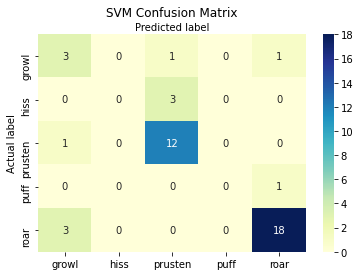

In [32]:
names = sorted(list(set(np.unique(y_test1)).union(set(y_pred_svc))))

print('Accuracy',clf_svc.score(X_test, y_test1))

cnf = confusion_matrix(y_test1, y_pred)
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))
sns.heatmap(cnf, annot = True, xticklabels = names, cmap= "YlGnBu", yticklabels = names)
ax.xaxis.set_label_position('top')
plt.title('SVM Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Naive Bayes

In [33]:
gnb = GaussianNB()

In [34]:
gnb.fit(X_train, y_train1)

GaussianNB()

In [35]:
gnb.score(X_train, y_train1)

0.89

In [36]:
gnb.score(X_test, y_test1)

0.813953488372093

In [37]:
y_pred_nb = gnb.predict(X_test)
y_prob_nb = gnb.predict_proba(X_test)

In [38]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_pred_nb))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_nb))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_pred_nb)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


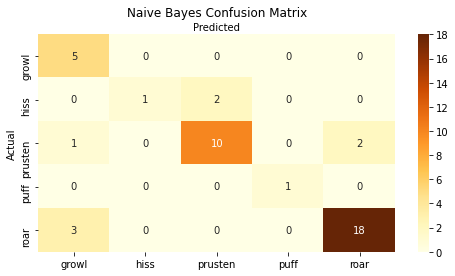

Accuracy 0.813953488372093


In [39]:
names_nb = sorted(list(set(np.unique(y_test1)).union(set(y_pred_nb))))
cnf = confusion_matrix(y_test1, y_pred_nb)
fig, ax = plt.subplots(figsize=(8,4))

sns.heatmap(cnf, annot=True, xticklabels=names_nb, yticklabels=names_nb,cmap= "YlOrBr")
plt.title('Naive Bayes Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
print('Accuracy',gnb.score(X_test, y_test1))

In [40]:
pred_df = pd.DataFrame(X_test.copy())
pred_df['Target'] = y_test1
pred_df['growl'] = y_prob_nb[:,0] 
pred_df['hiss'] = y_prob_nb[:,1]
pred_df['mew'] = y_prob_nb[:,2]
pred_df['prusten'] = y_prob_nb[:,3]
pred_df['puff'] = y_prob_nb[:,4]
pred_df['roar'] = y_prob_nb[:,5]
pred_df['Predicted'] = y_pred_nb
pred_df = pred_df[pred_df['Target'] != pred_df['Predicted']]
pred_df.to_csv('Mislabeled Panterinae Calls With Naive Bayes.csv', index=False)
pred_df.head(15)

,Partials,Zero_Crossings,Duration,Amp_range,Avg_amp,Freq_range,Pulses_per_Sec,MFCC,Spectral Rolloff,Melspectrogram,...,Chroma_StFt,Tonnetz,Target,growl,hiss,mew,prusten,puff,roar,Predicted
404,-0.424178,-0.489087,-0.476623,-0.824471,-0.721404,-1.230977,-0.807648,-0.557545,0.095090,-0.271412,...,0.076964,-1.249815,prusten,4.885191e-05,2.770935e-27,0.000000e+00,0.000000e+00,4.873075e-04,9.994638e-01,roar
581,3.944761,3.206808,2.620788,2.066188,1.054440,1.727119,-0.057579,-0.617610,0.705331,0.740748,...,0.106174,0.046918,roar,5.872329e-01,0.000000e+00,8.143523e-128,0.000000e+00,0.000000e+00,4.127671e-01,growl
584,4.886343,5.150497,2.620788,2.955100,1.019548,1.709992,1.173821,-0.249969,1.403523,0.713708,...,0.395891,-0.781327,roar,9.789980e-01,0.000000e+00,2.270580e-268,0.000000e+00,0.000000e+00,2.100202e-02,growl
385,-0.386515,-0.526238,-0.476623,-0.591230,-0.682572,-1.205170,-0.731349,-0.471441,-0.501959,-0.268885,...,0.411776,-1.424313,prusten,8.850934e-05,1.738982e-06,0.000000e+00,0.000000e+00,1.743167e-02,9.824781e-01,roar
407,0.103108,-0.515473,-0.605682,1.593539,0.601862,0.517530,1.055904,1.566079,0.444750,0.268902,...,1.175930,-0.398267,prusten,9.675383e-01,0.000000e+00,0.000000e+00,2.616414e-07,0.000000e+00,3.246145e-02,growl
375,-0.386515,-0.479441,-0.605682,-0.796778,-0.598478,-0.286325,0.488669,-0.382277,-0.029835,-0.267777,...,1.333358,-0.952526,hiss,2.813043e-15,7.203945e-15,0.000000e+00,1.000000e+00,8.055781e-19,1.286994e-12,prusten
377,-0.386515,-0.538000,-0.605682,-0.754791,-0.518260,-0.457358,0.023166,-0.017599,0.050116,-0.262161,...,1.095874,-1.701586,hiss,1.434837e-17,1.034059e-04,0.000000e+00,9.998966e-01,6.327918e-28,2.344542e-14,prusten
585,1.195343,3.438055,6.234434,2.061427,1.067648,1.557506,-0.324819,0.203484,-0.310410,0.644313,...,-0.391450,-0.238836,roar,7.072399e-01,0.000000e+00,7.940144e-227,0.000000e+00,0.000000e+00,2.927601e-01,growl


## Logistic Regression

In [41]:
lr = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight="balanced")

In [42]:
lr.fit(X_train,y_train1)

LogisticRegression(class_weight='balanced', multi_class='ovr',
                   solver='liblinear')

In [43]:
lr.score(X_train, y_train1)

0.89

In [44]:
lr.score(X_test, y_test1)

0.8604651162790697

In [45]:
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)

In [46]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_pred_lr))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_lr))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_pred_lr)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'hiss' 'mew' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
{'mew'}
4. Tested for but not predicted
set()


Accuracy 0.8604651162790697


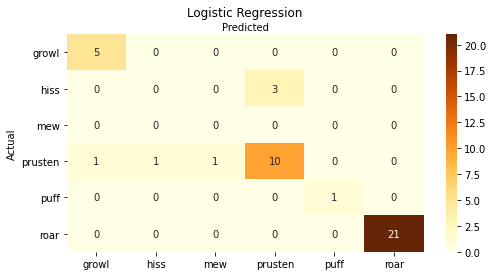

In [47]:
names_lr = sorted(list(set(np.unique(y_test1)).union(set(y_pred_lr))))
cnf = confusion_matrix(y_test1, y_pred_lr)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',lr.score(X_test, y_test1))

sns.heatmap(cnf, annot=True, xticklabels=names_lr, yticklabels=names_lr,cmap= "YlOrBr")
plt.title('Logistic Regression')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [48]:
pred_df = pd.DataFrame(X_test.copy())
pred_df['Target'] = y_test1
pred_df['growl'] = y_prob_lr[:,0] 
pred_df['hiss'] = y_prob_lr[:,1]
pred_df['mew'] = y_prob_lr[:,2]
pred_df['prusten'] = y_prob_lr[:,3]
pred_df['puff'] = y_prob_lr[:,4]
pred_df['roar'] = y_prob_lr[:,5]
pred_df['Predicted'] = y_pred_lr
pred_df = pred_df[pred_df['Target'] != pred_df['Predicted']]
pred_df.to_csv('Mislabeled Panterinae Calls With Logistic Regression.csv', index=False)
pred_df.head(15)

,Partials,Zero_Crossings,Duration,Amp_range,Avg_amp,Freq_range,Pulses_per_Sec,MFCC,Spectral Rolloff,Melspectrogram,...,Chroma_StFt,Tonnetz,Target,growl,hiss,mew,prusten,puff,roar,Predicted
382,-0.198198,-0.432582,-0.605682,-0.059455,-0.247209,1.623747,1.123726,-1.945481,0.440502,-0.202451,...,-0.121651,0.174109,prusten,0.013432,0.014583,0.434144,0.414696,0.014114,0.109031,mew
398,-0.424178,-0.610871,-0.605682,-0.006987,0.144097,-0.799424,-0.564107,0.714125,-1.373640,-0.149853,...,1.007178,0.519259,prusten,0.132101,0.457741,0.031720,0.321739,0.011532,0.045168,hiss
407,0.103108,-0.515473,-0.605682,1.593539,0.601862,0.517530,1.055904,1.566079,0.444750,0.268902,...,1.175930,-0.398267,prusten,0.664127,0.108935,0.023315,0.123501,0.038982,0.041139,growl
375,-0.386515,-0.479441,-0.605682,-0.796778,-0.598478,-0.286325,0.488669,-0.382277,-0.029835,-0.267777,...,1.333358,-0.952526,hiss,0.041218,0.439217,0.029864,0.467779,0.009448,0.012474,prusten
377,-0.386515,-0.538000,-0.605682,-0.754791,-0.518260,-0.457358,0.023166,-0.017599,0.050116,-0.262161,...,1.095874,-1.701586,hiss,0.016239,0.452841,0.011151,0.499353,0.002499,0.017916,prusten
376,-0.424178,-0.537129,-0.605682,-0.732839,-0.585146,-0.753001,-0.064694,-0.047318,-0.124902,-0.266568,...,1.154942,-1.740241,hiss,0.024201,0.463731,0.007478,0.487492,0.003852,0.013246,prusten


## KNN

In [49]:
knn = KNeighborsClassifier()

In [50]:
knn.fit(X_train, y_train1)

KNeighborsClassifier()

In [51]:
knn.score(X_train, y_train1)

0.85

In [52]:
knn.score(X_test, y_test1)

0.9534883720930233

In [53]:
y_pred_knn = knn.predict(X_test)

In [54]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_pred_knn))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_knn))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_pred_knn)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.9534883720930233


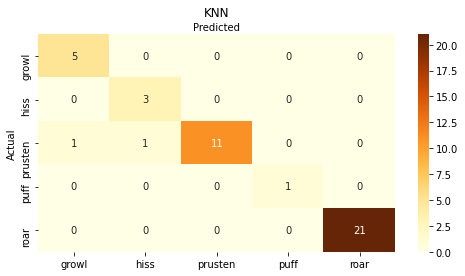

In [55]:
names_knn = sorted(list(set(np.unique(y_test1)).union(set(y_pred_knn))))
cnf = confusion_matrix(y_test1, y_pred_knn)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',knn.score(X_test, y_test1))

sns.heatmap(cnf, annot=True, xticklabels=names_knn, yticklabels=names_knn,cmap= "YlOrBr")
plt.title('KNN')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Decision Tree Classifier

In [56]:
cart = DecisionTreeClassifier()

In [57]:
cart.fit(X_train, y_train1)

DecisionTreeClassifier()

In [58]:
cart.score(X_train, y_train1)

1.0

In [59]:
cart.score(X_test, y_test1)

0.7209302325581395

In [60]:
y_pred_cart = cart.predict(X_test)

In [61]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_pred_cart))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_cart))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_pred_cart)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'hiss' 'mew' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
{'mew'}
4. Tested for but not predicted
set()


Accuracy 0.7209302325581395


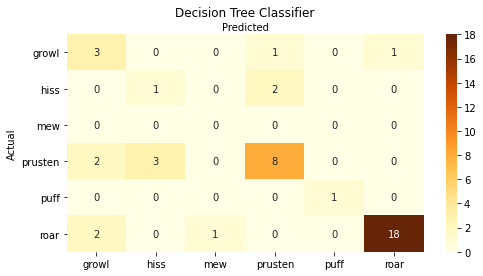

In [62]:
names_cart = sorted(list(set(np.unique(y_test1)).union(set(y_pred_cart))))
cnf = confusion_matrix(y_test1, y_pred_cart)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',cart.score(X_test, y_test1))

sns.heatmap(cnf, annot=True, xticklabels=names_cart, yticklabels=names_cart,cmap= "YlOrBr")
plt.title('Decision Tree Classifier')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Random Forest Classifier

In [63]:
rf = RandomForestClassifier()

In [64]:
rf.fit(X_train, y_train1)

RandomForestClassifier()

In [65]:
rf.score(X_train, y_train1)

1.0

In [66]:
rf.score(X_test, y_test1)

0.8372093023255814

In [67]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)

In [68]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_pred_rf))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_rf))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_pred_rf)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'prusten' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'puff', 'hiss'}


Accuracy 0.8372093023255814


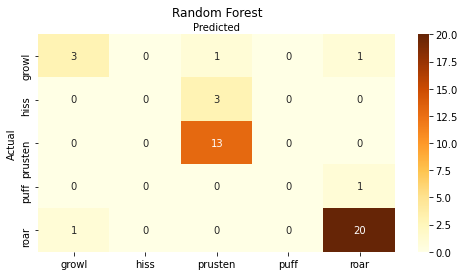

In [69]:
names_rf = sorted(list(set(np.unique(y_test1)).union(set(y_pred_rf))))
cnf = confusion_matrix(y_test1, y_pred_rf)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',rf.score(X_test, y_test1))

sns.heatmap(cnf, annot=True, xticklabels=names_rf, yticklabels=names_rf,cmap= "YlOrBr")
plt.title('Random Forest')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


In [70]:
rf.classes_

array(['growl', 'hiss', 'mew', 'prusten', 'puff', 'roar'], dtype=object)

In [71]:
pred_df = pd.DataFrame(X_test.copy())
pred_df['Target'] = y_test1
pred_df['growl'] = y_prob_rf[:,0] 
pred_df['hiss'] = y_prob_rf[:,1]
pred_df['mew'] = y_prob_rf[:,2]
pred_df['prusten'] = y_prob_rf[:,3]
pred_df['puff'] = y_prob_rf[:,4]
pred_df['roar'] = y_prob_rf[:,5]
pred_df['Predicted'] = y_pred_rf
pred_df = pred_df[pred_df['Target'] != pred_df['Predicted']]
pred_df.head(15)

,Partials,Zero_Crossings,Duration,Amp_range,Avg_amp,Freq_range,Pulses_per_Sec,MFCC,Spectral Rolloff,Melspectrogram,...,Chroma_StFt,Tonnetz,Target,growl,hiss,mew,prusten,puff,roar,Predicted
452,0.178434,1.971545,0.426788,1.929424,0.536933,1.322674,1.148045,-1.395524,1.198599,0.259737,...,-0.454438,-0.266165,roar,0.48,0.00,0.08,0.04,0.00,0.40,growl
459,0.743383,-0.030266,-0.218505,2.959513,1.687206,1.625198,1.896738,0.210251,0.137189,0.694801,...,-0.066508,-0.333012,growl,0.39,0.00,0.15,0.00,0.00,0.46,roar
471,-0.235862,-0.115148,0.297730,0.119825,-0.734150,1.224377,-0.808034,-2.153850,-0.571309,-0.264730,...,-3.987409,-0.172403,puff,0.02,0.00,0.01,0.00,0.28,0.69,roar
375,-0.386515,-0.479441,-0.605682,-0.796778,-0.598478,-0.286325,0.488669,-0.382277,-0.029835,-0.267777,...,1.333358,-0.952526,hiss,0.02,0.27,0.00,0.68,0.02,0.01,prusten
576,-0.160535,-0.607573,-0.605682,0.974286,1.701613,0.173304,0.630236,1.746950,-0.313524,0.586416,...,0.628175,-0.369724,growl,0.35,0.01,0.01,0.54,0.00,0.09,prusten
377,-0.386515,-0.538000,-0.605682,-0.754791,-0.518260,-0.457358,0.023166,-0.017599,0.050116,-0.262161,...,1.095874,-1.701586,hiss,0.01,0.31,0.00,0.67,0.01,0.00,prusten
376,-0.424178,-0.537129,-0.605682,-0.732839,-0.585146,-0.753001,-0.064694,-0.047318,-0.124902,-0.266568,...,1.154942,-1.740241,hiss,0.00,0.25,0.00,0.74,0.01,0.00,prusten


In [72]:
pred_df.shape

(7, 21)

In [73]:
pred_df.to_csv('Mislabeled Panterinae Calls With Random Forest.csv', index=False)

In [74]:
#The data is unbalanced, this could be fixed by updating the class weights 
#Or getting more varied data
df['Call'].value_counts()

roar       65
prusten    44
growl      20
hiss        6
puff        5
mew         3
Name: Call, dtype: int64

# Species Classification

## Splitting data

In [75]:
y_train2 = y_train.Species
y_test2 = y_test.Species

In [76]:
## LightGBM

In [77]:
import lightgbm as lgb
lgb = lgb.LGBMClassifier()
lgb.fit(X_train, y_train2)

LGBMClassifier()

In [78]:
lgb.score(X_train, y_train2)

1.0

In [79]:
lgb.score(X_test,y_test2)

0.7674418604651163

## XGBoost

In [80]:
parameters = dict(
    objective='multi:softprob',
    random_state = 30,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.4,
    tree_method='gpu_hist')
#eval_metric='mlogloss'

clf = XGBClassifier(**parameters, n_estimators=1200)

In [81]:
clf.fit(X_train, y_train2)

C:\Users\exant\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:30:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1200, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=30, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [82]:
clf.score(X_train, y_train2)

1.0

In [83]:
clf.score(X_test,y_test2)

0.7906976744186046

In [84]:
y_pred = clf.predict(X_test)

In [85]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_pred))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_pred)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'Snow leopard'}


Accuracy 0.7906976744186046


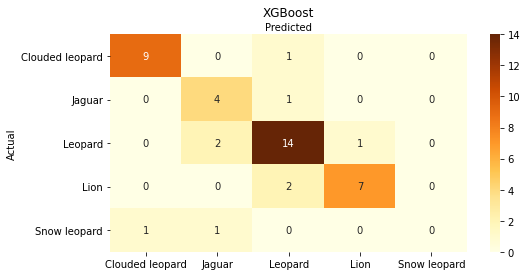

In [86]:
names = sorted(list(set(np.unique(y_test2)).union(set(y_pred))))
cnf = confusion_matrix(y_test2, y_pred)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',clf.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names, yticklabels=names,cmap= "YlOrBr")
plt.title('XGBoost')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


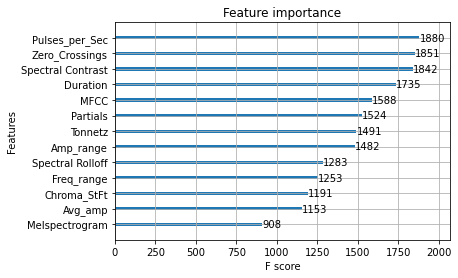

In [87]:
plot_importance(clf)
figsize=(8,4)

## SVM

In [88]:
clf_svc = SVC()

In [89]:
clf_svc.fit(X_train, y_train2)

SVC()

In [90]:
clf_svc.score(X_train, y_train2)

0.82

In [91]:
clf_svc.score(X_test, y_test2)

0.7906976744186046

In [92]:
y_pred_svc=clf_svc.predict(X_test)

In [93]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_pred_svc))
print('3. False Positive')
print(set(np.unique(y_pred_svc))-set(np.unique(y_test2)))
print('4. False Negative')
print(set(np.unique(y_test2))-set(np.unique(y_pred_svc)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
3. False Positive
set()
4. False Negative
{'Snow leopard'}


Accuracy 0.7906976744186046


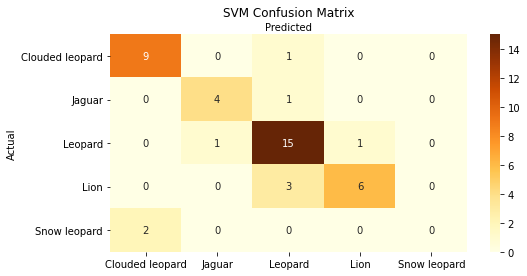

In [94]:
names_svc = sorted(list(set(np.unique(y_test2)).union(set(y_pred_svc))))
cnf = confusion_matrix(y_test2, y_pred_svc)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',clf_svc.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_svc, yticklabels=names_svc,cmap= "YlOrBr")
plt.title('SVM Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)



In [95]:
## Naive Bayes

In [96]:
gnb = GaussianNB()

In [97]:
gnb.fit(X_train, y_train2)

GaussianNB()

In [98]:
gnb.score(X_train, y_train2)

0.73

In [99]:
gnb.score(X_test, y_test2)

0.6046511627906976

In [100]:
y_pred_nb = gnb.predict(X_test)

In [101]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_pred_nb))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_nb))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_pred_nb)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.6046511627906976


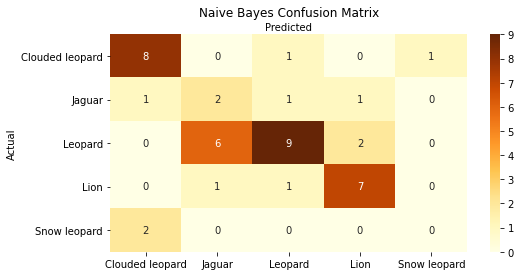

In [102]:
names_nb = sorted(list(set(np.unique(y_test2)).union(set(y_pred_nb))))
cnf = confusion_matrix(y_test2, y_pred_nb)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',gnb.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_nb, yticklabels=names_nb,cmap= "YlOrBr")
plt.title('Naive Bayes Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


In [103]:
## Logistic Regression

In [104]:
lr = LogisticRegression(solver='liblinear', multi_class='ovr')

In [105]:
lr.fit(X_train,y_train2)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [106]:
lr.score(X_train, y_train2)

0.83

In [107]:
lr.score(X_test, y_test2)

0.7209302325581395

In [108]:
y_pred_lr = lr.predict(X_test)

In [109]:
print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_pred_lr))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_lr))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_pred_lr)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard' 'growl' 'hiss'
 'prusten' 'puff' 'roar']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'roar', 'puff', 'growl', 'prusten', 'hiss', 'Snow leopard'}


Accuracy 0.7209302325581395


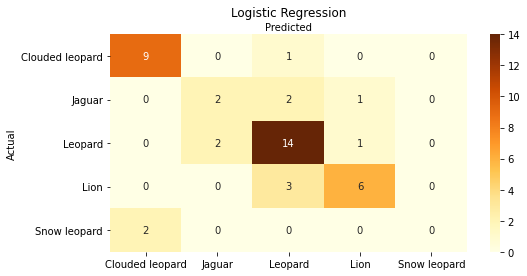

In [110]:
names_lr = sorted(list(set(np.unique(y_test2)).union(set(y_pred_lr))))
cnf = confusion_matrix(y_test2, y_pred_lr)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',lr.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_lr, yticklabels=names_lr,cmap= "YlOrBr")
plt.title('Logistic Regression')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


In [111]:
## KNN

In [112]:
knn = KNeighborsClassifier()

In [113]:
knn.fit(X_train, y_train2)

KNeighborsClassifier()

In [114]:
knn.score(X_train, y_train2)

0.81

In [115]:
knn.score(X_test, y_test2)

0.813953488372093

In [116]:
y_pred_knn = knn.predict(X_test)

In [117]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_pred_knn))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_knn))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_pred_knn)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'Snow leopard'}


Accuracy 0.813953488372093


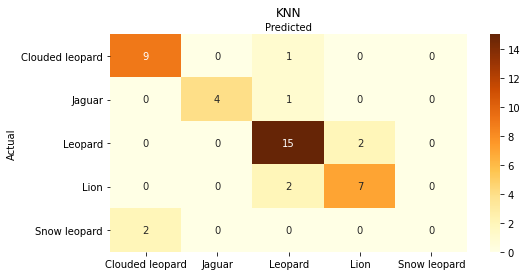

In [118]:
names_knn = sorted(list(set(np.unique(y_test2)).union(set(y_pred_knn))))
cnf = confusion_matrix(y_test2, y_pred_knn)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',knn.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_knn, yticklabels=names_knn,cmap= "YlOrBr")
plt.title('KNN')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Decision Tree Classifier

In [119]:
cart = DecisionTreeClassifier()

In [120]:
cart.fit(X_train, y_train2)

DecisionTreeClassifier()

In [121]:
cart.score(X_train, y_train2)

1.0

In [122]:
cart.score(X_test, y_test2)

0.6976744186046512

In [123]:
y_pred_cart = cart.predict(X_test)

In [124]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_pred_cart))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_cart))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_pred_cart)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.6976744186046512


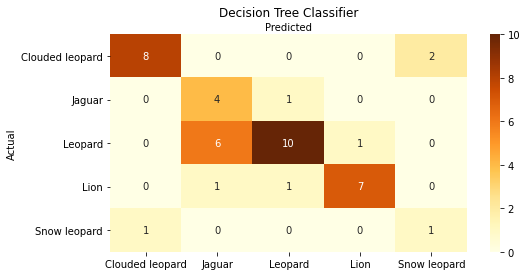

In [125]:
names_cart = sorted(list(set(np.unique(y_test2)).union(set(y_pred_cart))))
cnf = confusion_matrix(y_test2, y_pred_cart)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',cart.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_cart, yticklabels=names_cart,cmap= "YlOrBr")
plt.title('Decision Tree Classifier')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Random Forest Classifier

In [126]:
rf = RandomForestClassifier()

In [127]:
rf.fit(X_train, y_train2)

RandomForestClassifier()

In [128]:
rf.score(X_train, y_train2)

1.0

In [129]:
rf.score(X_test, y_test2)

0.8372093023255814

In [130]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)

In [131]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_pred_rf))
print('3. Not tested for but predicted')
print(set(np.unique(y_pred_rf))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_pred_rf)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.8372093023255814


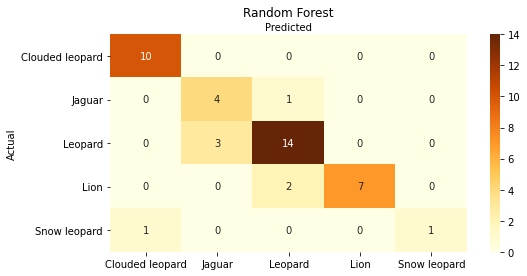

In [132]:
names_rf = sorted(list(set(np.unique(y_test2)).union(set(y_pred_rf))))
cnf = confusion_matrix(y_test2, y_pred_rf)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',rf.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_rf, yticklabels=names_rf,cmap= "YlOrBr")
plt.title('Random Forest')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [133]:
df_test = pd.DataFrame(X_test.copy())
df_test['Target'] = y_test2
df_test['Clouded leopard'] = y_prob_rf[:,0] 
df_test['Jaguar'] = y_prob_rf[:,1]
df_test['Leopard'] = y_prob_rf[:,2]
df_test['Lion'] = y_prob_rf[:,3]
df_test['Snow leopard'] = y_prob_rf[:,4]
df_test['Predicted'] = y_pred_rf
df_test = df_test[df_test['Target'] != df_test['Predicted']]
df_test.head(15)

,Partials,Zero_Crossings,Duration,Amp_range,Avg_amp,Freq_range,Pulses_per_Sec,MFCC,Spectral Rolloff,Melspectrogram,Spectral Contrast,Chroma_StFt,Tonnetz,Target,Clouded leopard,Jaguar,Leopard,Lion,Snow leopard,Predicted
441,0.630394,0.046028,1.201141,0.508935,0.488108,1.417937,-0.427950,0.780502,-1.207341,-0.017260,0.025955,-0.200132,0.518906,Leopard,0.00,0.47,0.35,0.18,0.00,Jaguar
407,0.103108,-0.515473,-0.605682,1.593539,0.601862,0.517530,1.055904,1.566079,0.444750,0.268902,-0.782793,1.175930,-0.398267,Jaguar,0.10,0.26,0.47,0.10,0.07,Leopard
576,-0.160535,-0.607573,-0.605682,0.974286,1.701613,0.173304,0.630236,1.746950,-0.313524,0.586416,-0.683571,0.628175,-0.369724,Lion,0.18,0.22,0.43,0.13,0.04,Leopard
450,-0.273525,0.081872,-0.089447,0.000090,-0.216937,0.335685,-0.820288,-1.269355,0.166827,-0.154831,0.145729,-0.159690,-0.311552,Leopard,0.02,0.44,0.38,0.14,0.02,Jaguar
480,-0.461841,-0.438805,-0.605682,-0.818058,-0.714751,-0.506836,-0.040031,-1.279127,0.528948,-0.271844,0.554038,0.935927,-0.722486,Snow leopard,0.44,0.42,0.03,0.07,0.04,Clouded leopard
435,0.404414,6.969290,4.298552,0.814830,-0.267440,1.540642,-0.310092,-0.321139,0.720737,-0.163044,-0.506030,-0.080896,-0.408211,Leopard,0.00,0.46,0.34,0.19,0.01,Jaguar
597,0.479741,1.002003,0.168671,0.938346,-0.342325,1.443202,0.542398,-1.564324,0.424325,-0.203654,0.466191,-0.042270,0.492505,Lion,0.01,0.33,0.41,0.20,0.05,Leopard


In [134]:
df_test.shape

(7, 20)

In [135]:
pred_df.to_csv('Mislabeled Panterinae Species With Random Forest.csv', index=False)

#The data is unbalanced, this could be fixed by updating the class weights 
#Or getting more varied data
df2['Species'].value_counts()